In [ ]:
file_name = '000006'
image_path = '/media/ssd3/lab/sypark/KITTI/object/2d_object/data_object_image_2/training/image_2/{file_name}.png'
velo_path = '/media/ssd3/lab/sypark/KITTI/object/2d_object/data_object_velodyne/training/velodyne/{file_name}.bin'
calib_path = '/media/ssd3/lab/sypark/KITTI/object/2d_object/data_object_calib/training/calib/{file_name}.txt'
label_file = '/media/ssd3/lab/sypark/KITTI/object/2d_object/data_object_label_2/training/label_2/{file_name}.txt'

lidar파일과 image파일 비교해보기

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW
[Open3D WARNING] [DrawGeometries] Failed creating OpenGL window.


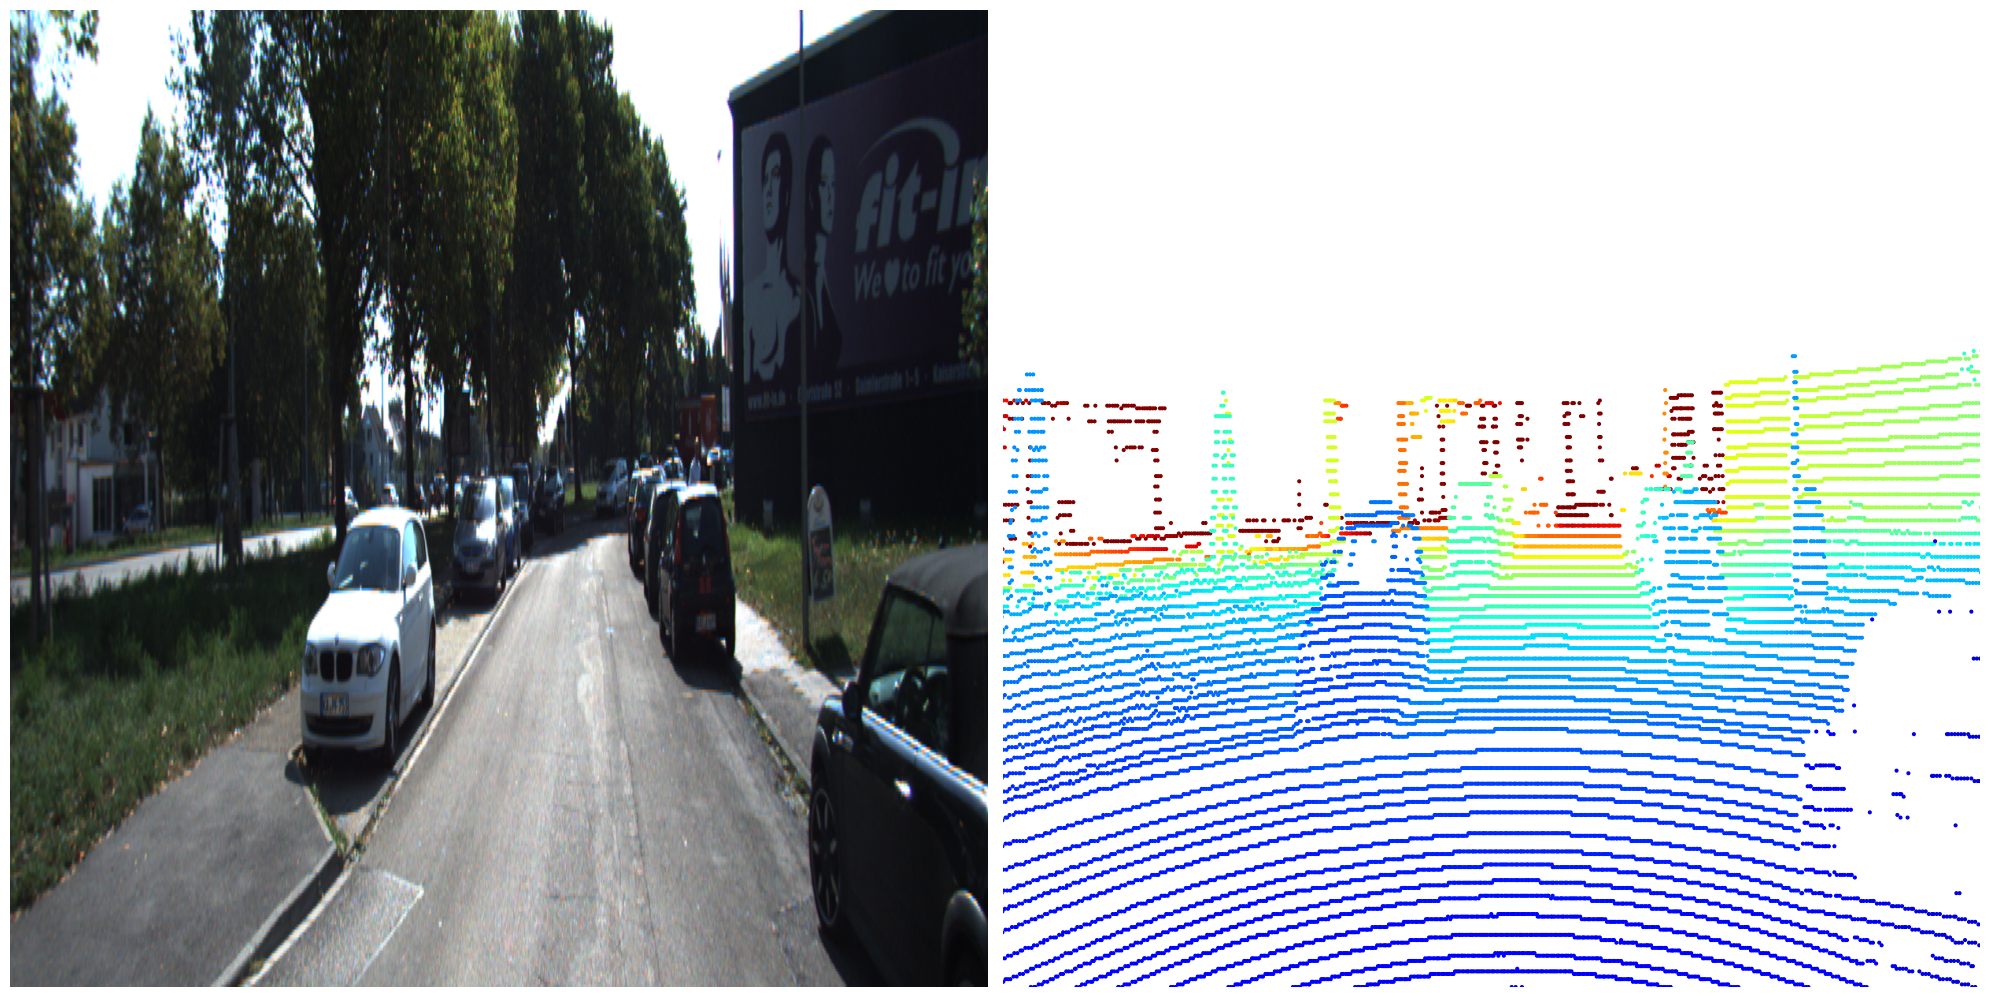

In [ ]:
import numpy as np
import open3d as o3d
import cv2
import matplotlib.pyplot as plt

def visualization_open3d(data):
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(data[:, :3])
    o3d.visualization.draw_geometries([pcd])

with open(velo_path, 'rb') as f:
    data = np.fromfile(f, dtype=np.float32).reshape(-1,4)

visualization_open3d(data)

def read_calib_file(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()

    P2 = np.array([float(i) for i in lines[2].split(' ')[1:]]).reshape(3,4)
    R0_rect = np.array([float(i) for i in lines[4].split(' ')[1:]]).reshape(3,3)
    Tr_velo_to_cam = np.array([float(i) for i in lines[5].split(' ')[1:]]).reshape(3,4)

    return P2, R0_rect, Tr_velo_to_cam

file_name = '000010'
image_path = f'/media/ssd3/lab/sypark/KITTI/object/2d_object/data_object_image_2/training/image_2/{file_name}.png'
# velo_path = f'/media/ssd3/lab/sypark/KITTI/object/2d_object/data_object_velodyne/training/velodyne/{file_name}.bin'
velo_path = f'/media/ssd3/lab/jojeon/KITTI/data_spoofing/velodyne/train_delete/000010/{file_name}-8.bin'

# /media/ssd3/lab/jojeon/KITTI/data_spoofing/velodyne/train_delete/000010/{file_name}-1.bin
calib_path = f'/media/ssd3/lab/sypark/KITTI/object/2d_object/data_object_calib/training/calib/{file_name}.txt'

P2, R0_rect, Tr_velo_to_cam = read_calib_file(calib_path)

R0 = np.eye(4)
R0[:3, :3] = R0_rect  # 3x3 행렬인 R0_rect을 4x4 행렬로 변환
Tr = np.vstack([Tr_velo_to_cam, [0, 0, 0, 1]])  # 3x4 행렬인 Tr_velo_to_cam를 4x4 행렬로 변환

# lidar 데이터 불러오기
with open(velo_path, 'rb') as f:
    data = np.fromfile(f, dtype=np.float32).reshape(-1,4)

XYZ1 = np.vstack([data[:, :3].T, np.ones((1, data.shape[0]))])

xyz = np.dot(P2, np.dot(R0, np.dot(Tr, XYZ1)))
z = xyz[2, :]
mask = z > 0
x = (xyz[0, mask] / z[mask]).astype(np.int32)
y = (xyz[1, mask] / z[mask]).astype(np.int32)
filtered_data = data[mask]

def visualization_plt(image_file, data, x, y):
    img = cv2.imread(image_file)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    aspect_ratio = float(img.shape[1]) / img.shape[0]

    fig, axs = plt.subplots(1, 2, figsize=(20, 25))

    axs[0].imshow(img_rgb)
    axs[0].axis('off')

    x_values = data[:, 0]

    x_min, x_max = np.percentile(x_values, 1), np.percentile(x_values, 99)

    scatter = axs[1].scatter(x, img.shape[0] - y, c=x_values, cmap='jet', marker='.', s=15, vmin=x_min, vmax=x_max)
    axs[1].set_xlim([0, img.shape[1]])
    axs[1].set_ylim([0, img.shape[0]])
    axs[1].axis('off')

    for ax in axs:
        ax.set_aspect(aspect_ratio)

    plt.tight_layout()
    plt.show()

visualization_plt(image_path, filtered_data, x, y)

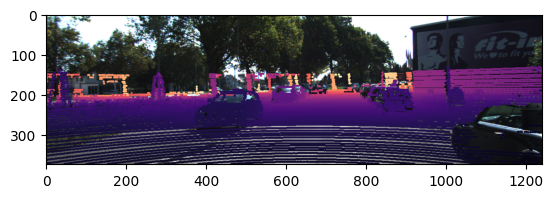

In [10]:
def visualization_projection(image_file, data, x, y):
    img = cv2.imread(image_file)
    img_mapped = img.copy()
    img_h, img_w = img.shape[:2]

    # 거리에 따라 color값을 다르게 주기 위한 부분
    x_normalized = (data[:, 0] - np.min(data[:, 0])) / (np.max(data[:, 0]) - np.min(data[:, 0]))
    colors = plt.cm.magma(x_normalized)

    for i, (ix, iy) in enumerate(zip(x, y)):
        if 0 <= ix < img_w and 0 <= iy < img_h:
            color = (colors[i] * 255).astype(np.uint8)[:3]
            color = (int(color[2]), int(color[1]), int(color[0]))
            cv2.circle(img_mapped, (ix, iy), radius=1, color=color, thickness=2)

    img_mapped_rgb = cv2.cvtColor(img_mapped, cv2.COLOR_BGR2RGB)

    plt.imshow(img_mapped_rgb)
    plt.show()


visualization_projection(image_path, filtered_data, x, y)

총정리

In [1]:
import numpy as np
import open3d as o3d
import cv2
import matplotlib.pyplot as plt

def visualization_open3d(data):
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(data[:, :3])
    vis = o3d.visualization.Visualizer()
    vis.create_window()
    vis.add_geometry(pcd)
    vis.run()
    vis.destroy_window()

def visualization_projection(image_file, data, x, y):
    img = cv2.imread(image_file)
    img_mapped = img.copy()
    img_h, img_w = img.shape[:2]

    # 거리에 따라 color값을 다르게 주기 위한 부분
    x_normalized = (data[:, 0] - np.min(data[:, 0])) / (np.max(data[:, 0]) - np.min(data[:, 0]))
    colors = plt.cm.magma(x_normalized)

    for i, (ix, iy) in enumerate(zip(x, y)):
        if 0 <= ix < img_w and 0 <= iy < img_h:
            color = (colors[i] * 255).astype(np.uint8)[:3]
            color = (int(color[2]), int(color[1]), int(color[0]))  # Convert from RGB to BGR for OpenCV
            cv2.circle(img_mapped, (ix, iy), radius=1, color=color, thickness=2)

    img_mapped_rgb = cv2.cvtColor(img_mapped, cv2.COLOR_BGR2RGB)

    plt.imshow(img_mapped_rgb)
    plt.axis('off')
    plt.show()

def read_calib_file(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()

    P2 = np.array([float(i) for i in lines[2].split(' ')[1:]]).reshape(3,4)
    R0_rect = np.array([float(i) for i in lines[4].split(' ')[1:]]).reshape(3,3)
    Tr_velo_to_cam = np.array([float(i) for i in lines[5].split(' ')[1:]]).reshape(3,4)

    return P2, R0_rect, Tr_velo_to_cam

def read_label_file(file_path):
    objects = []
    with open(file_path, 'r') as f:
        for line in f.readlines():
            obj = line.strip().split(' ')
            object_info = {
                'class': obj[0],
                'bbox3d': np.array([float(obj[11]), float(obj[12]), float(obj[13]),  # (x, y, z) center
                                    float(obj[8]), float(obj[9]), float(obj[10]),  # (h, w, l)
                                    float(obj[14])])  # rotation_y
            }
            objects.append(object_info)
    return objects

def filter_points_outside_bbox(point_cloud, bbox3d):
    x, y, z, h, w, l, ry = bbox3d
    R = np.array([[np.cos(ry), -np.sin(ry)], [np.sin(ry), np.cos(ry)]])
    shifted_points = point_cloud[:, :2] - np.array([x, y])
    rotated_points = np.dot(shifted_points, R.T)
    mask = (
        (rotated_points[:, 0] >= -w / 2) & (rotated_points[:, 0] <= w / 2) &
        (rotated_points[:, 1] >= -l / 2) & (rotated_points[:, 1] <= l / 2) &
        (point_cloud[:, 2] >= z - h / 2) & (point_cloud[:, 2] <= z + h / 2)
    )
    return point_cloud[~mask]

file_name = '000006'
image_file = f'/media/ssd3/lab/sypark/KITTI/object/2d_object/data_object_image_2/training/image_2/{file_name}.png'
velo_file = f'/media/ssd3/lab/sypark/KITTI/object/2d_object/data_object_velodyne/training/velodyne/{file_name}.bin'
calib_file = f'/media/ssd3/lab/sypark/KITTI/object/2d_object/data_object_calib/training/calib/{file_name}.txt'
label_file = f'/media/ssd3/lab/sypark/KITTI/object/2d_object/data_object_label_2/training/label_2/{file_name}.txt'

P2, R0_rect, Tr_velo_to_cam = read_calib_file(calib_file)
objects = read_label_file(label_file)

R0 = np.eye(4)
R0[:3, :3] = R0_rect
Tr = np.vstack([Tr_velo_to_cam, [0, 0, 0, 1]])

with open(velo_file, 'rb') as f:
    data = np.fromfile(f, dtype=np.float32).reshape(-1,4)

XYZ1 = np.vstack([data[:, :3].T, np.ones((1, data.shape[0]))])

xyz = np.dot(P2, np.dot(R0, np.dot(Tr, XYZ1)))
z = xyz[2, :]
mask = z > 0
x = (xyz[0, mask] / z[mask]).astype(np.int32)
y = (xyz[1, mask] / z[mask]).astype(np.int32)
filtered_data = data[mask]

# 특정 라벨에 해당하는 객체의 포인트 제거 (예: 자동차)
for obj in objects:
    if obj['class'] == 'Car':  # Car를 타겟으로 설정
        filtered_data = filter_points_outside_bbox(filtered_data, obj['bbox3d'])

visualization_open3d(filtered_data)
visualization_projection(image_file, filtered_data, x, y)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


: 